In [1]:
pip install transformers


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 2.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-y0y6rvw5
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-y0y6rvw5
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 1.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6857 sha256=c2a9d39d776a953dc55191fd24c80019261d3bcd40342e380bb3c621f4701b60
  Stored in directory: /tmp/pip-ephem-wheel-cache-2tjndv5v/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186457 sha256=ad3158dd9a1f9c3fe8038c943a20bda

In [4]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from normalizer import normalize #buet_bert

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 

# Load your dataset
train_data = pd.read_excel("/kaggle/input/threshold-new-data/train_data_new.xlsx")
val_data = pd.read_excel("/kaggle/input/threshold-new-data/val_data_new.xlsx")
test_data = pd.read_excel("/kaggle/input/test-data-suffled-and-removed/new Test Data_suffled.xlsx")
# Define the allowed labels
allowed_labels = ['entailment', 'contradiction', 'neutral']
test_labels = ['contradiction', 'entailment', 'neutral'] 

# Filter the training dataset to keep only rows with allowed labels
train_data = train_data[train_data['label'].isin(allowed_labels)]

# Filter the validation dataset to keep only rows with allowed labels
val_data = val_data[val_data['label'].isin(allowed_labels)]

# Filter the test dataset to keep only rows with allowed labels
test_data = test_data[test_data['label'].isin(allowed_labels)]

In [6]:
# Extract unique labels from each dataset
unique_train_labels = train_data['label'].unique()
unique_val_labels = val_data['label'].unique()
unique_test_labels = test_data['label'].unique()

# Print the unique labels for each dataset
print("Unique Labels in Training Data:", unique_train_labels)
print("Unique Labels in Validation Data:", unique_val_labels)
print("Unique Labels in Test Data:", unique_test_labels)

Unique Labels in Training Data: ['contradiction' 'neutral' 'entailment']
Unique Labels in Validation Data: ['contradiction' 'entailment' 'neutral']
Unique Labels in Test Data: ['entailment' 'contradiction' 'neutral']


In [7]:
# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("csebuetnlp/banglabert_large")
model = BertForSequenceClassification.from_pretrained("csebuetnlp/banglabert_large", num_labels=3)

# Encode the labels
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])
val_data['label'] = label_encoder.transform(val_data['label'])
test_data['label'] = label_encoder.transform(test_data['label'])
unique_labels = train_data['label'].unique()
print("Unique Labels:", unique_labels)
# Tokenize and prepare the data
class TextEntailmentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        premise = self.data.iloc[idx]['sentence']
        hypothesis = self.data.iloc[idx]['output']
        label = self.data.iloc[idx]['label']

        encoding = self.tokenizer(premise, hypothesis, padding='max_length', truncation=True, max_length=self.max_length)
        inputs = {k: torch.tensor(v) for k, v in encoding.items()}
        inputs['labels'] = torch.tensor(label)

        return inputs
original_labels = label_encoder.inverse_transform(unique_labels)
print("Original Labels:", original_labels)
train_dataset = TextEntailmentDataset(train_data, tokenizer)
val_dataset = TextEntailmentDataset(val_data, tokenizer)
test_dataset = TextEntailmentDataset(test_data, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 5
acc_list=[]
loss_list=[]
# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    true_labels = []
    predicted_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        total_val_loss = 0
        for batch in val_loader:
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            labels = batch['labels']
            labels = batch['labels'].squeeze()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
        
        
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")
    acc_list.append(accuracy)
    loss_list.append(avg_val_loss)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert_large and are newly initialized: ['encoder.layer.21.attention.self.key.bias', 'encoder.layer.21.attention.self.query.bias', 'encoder.layer.12.attention.self.key.weight', 'encoder.layer.23.attention.self.query.bias', 'encoder.layer.20.attention.output.dense.bias', 'encoder.layer.9.attention.output.dense.weight', 'encoder.layer.1.attention.output.LayerNorm.bias', 'encoder.layer.4.intermediate.dense.bias', 'encoder.layer.1.output.LayerNorm

Unique Labels: [0 2 1]
Original Labels: ['contradiction' 'neutral' 'entailment']
Test Accuracy: 0.3883
Epoch 1, Validation Loss: 1.1054
Test Accuracy: 0.3538
Epoch 2, Validation Loss: 1.0951
Test Accuracy: 0.4323
Epoch 3, Validation Loss: 1.0520
Test Accuracy: 0.4616
Epoch 4, Validation Loss: 1.0363
Test Accuracy: 0.4478
Epoch 5, Validation Loss: 1.1917


In [8]:
# Testing loop
model.eval()
true_labels = []
predicted_labels = []
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        labels = batch['labels']
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
      
report = classification_report(true_labels, predicted_labels, target_names=test_labels)
print(f"Test Classification Report:\n{report}")

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.6f}")

Test Classification Report:
               precision    recall  f1-score   support

contradiction       0.79      0.32      0.46       350
   entailment       0.25      0.11      0.16       379
      neutral       0.42      0.88      0.57       388

     accuracy                           0.44      1117
    macro avg       0.49      0.44      0.40      1117
 weighted avg       0.48      0.44      0.40      1117

Test Accuracy: 0.444047


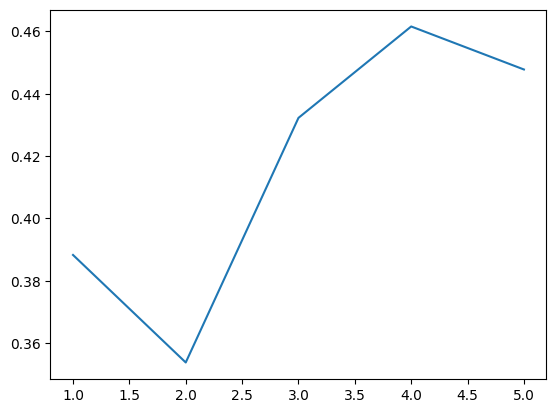

In [9]:
plt.plot(range(1,num_epochs+1),acc_list)

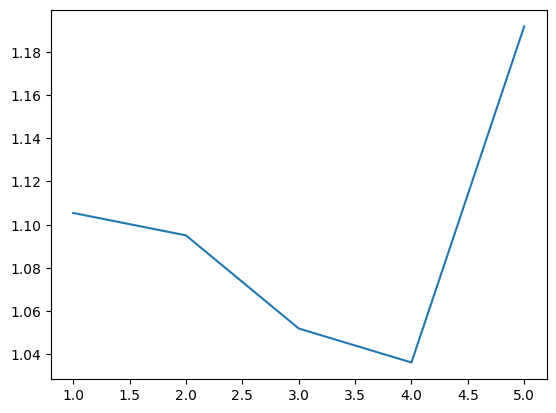

In [10]:
plt.plot(range(1,num_epochs+1),loss_list)